In [1]:
import matplotlib.pyplot as plt
import json

%matplotlib inline

In [3]:
# Load anchors (BPG)

anchor_filename = "/home/xyhang/projects/VCIP2023-grand-challenge/experiments/anchors/classa/bpg/results.json"
with open(anchor_filename, "r") as fin:
    anchor_data = json.load(fin)

In [8]:
qps = [13, 17, 21, 25, 29, 33, 37, 41, 45, 49]
bpps_anchor = []
psnrs_anchor = []

for qp in qps:
    bpps_anchor.append(anchor_data[f"qp={qp}"]["level=8"]["IMG_6726"]["bpp"])
    psnrs_anchor.append(anchor_data[f"qp={qp}"]["level=8"]["IMG_6726"]["PSNR"])

In [26]:
# Load main data

import os
from dataclasses import dataclass
import numpy as np


@dataclass
class Data:
    time: float
    psnr: float
    legal: bool
    stage: str


levels = range(7)
qscales = [0.3, 0.4, 0.5, 0.6, 0.7]
timepoint = range(0, 600, 10)

base_dir = (
    "/home/xyhang/projects/VCIP2023-grand-challenge/experiments/SAv1/ablation/6K/"
)

# Load bpp info

result_file = "results_ablation.json"

with open(result_file, "r") as f:
    result_data = json.load(f)

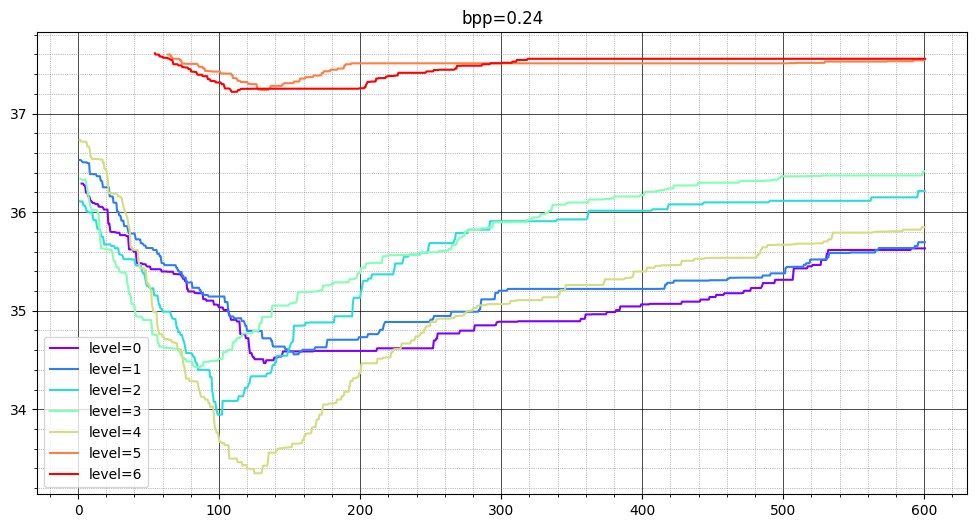

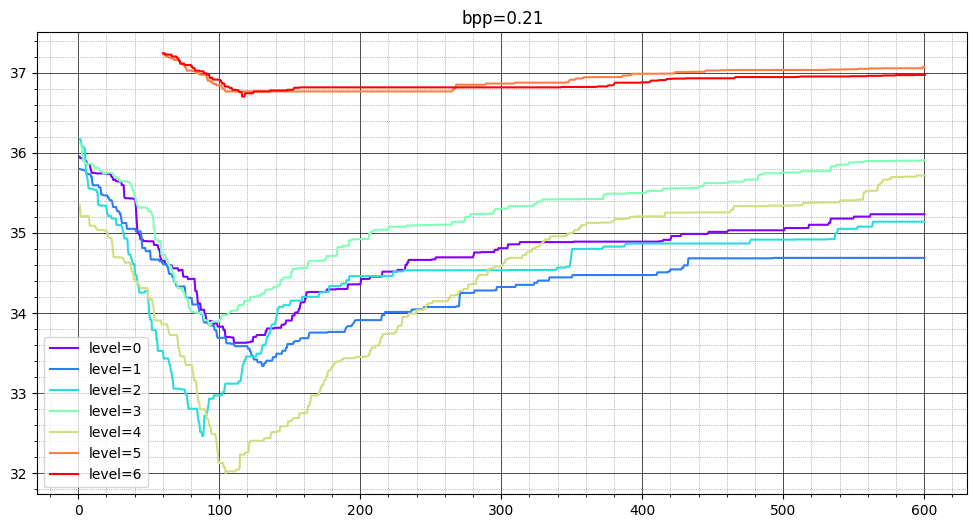

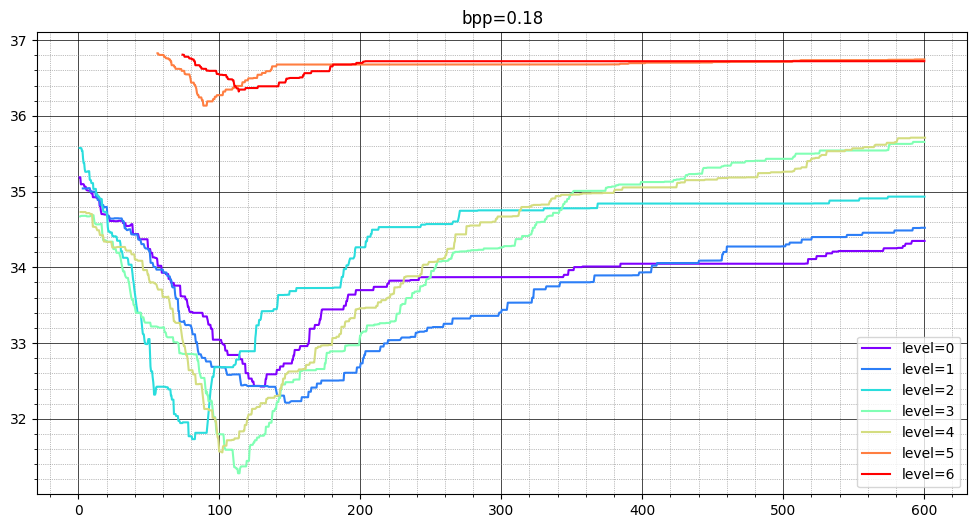

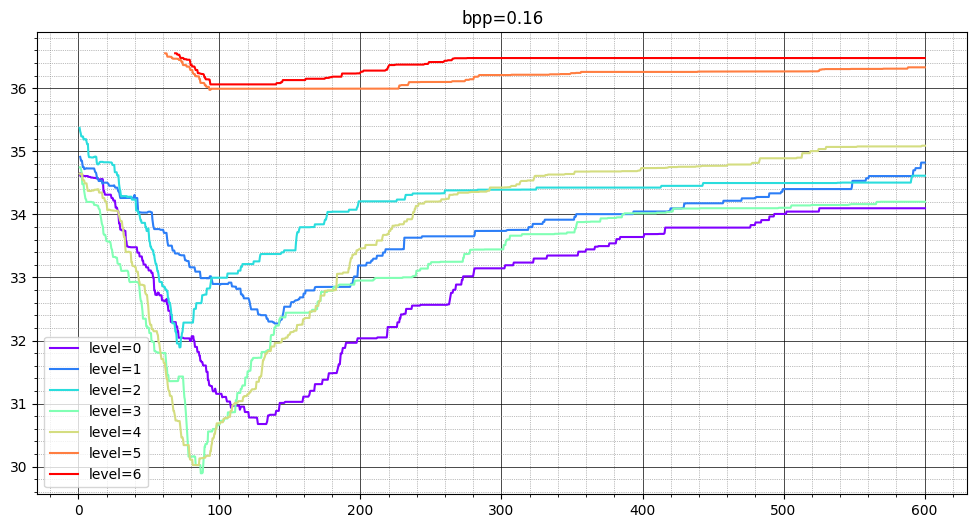

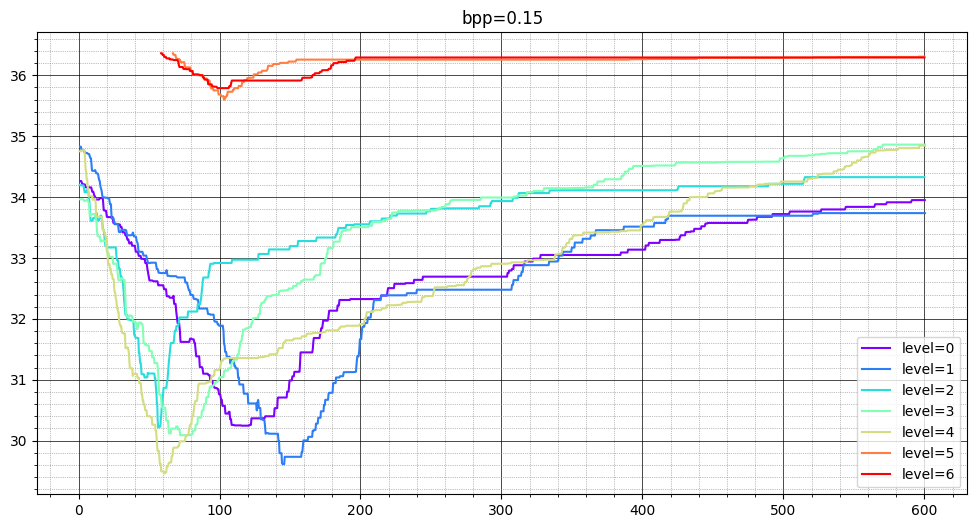

In [27]:
def read_timeline_data(level, qscale):
    jsonfile = os.path.join(base_dir, "PSNR", f"level-{level}", "time_limit-600", f"qscale-{qscale}", "IMG_6726_statistics.json")
    with open(jsonfile, 'r') as f:
        data = json.load(f)
        results = []
        for step_results in data["step_results"]:
            results.append(Data(psnr=-step_results['best_loss'], legal=step_results['legal'], time=step_results['time'], stage=step_results['stage']))
        return results

colors = plt.cm.rainbow(np.linspace(0, 1, len(levels)))

for qscale in qscales:
    bpp = result_data["level=6"][f"qscale={qscale}"]["avg_bpp"]
    plt.figure(figsize=(12, 6))
    for color, level in zip(colors, levels):
        results = read_timeline_data(level, qscale)
        xs = [r.time for r in results]
        ys = [r.psnr for r in results]
        plt.plot(xs, ys, label=f"level={level}", color=color)
    plt.legend()
    plt.grid(which='major', linestyle='-', linewidth='0.5', color='black')
    plt.minorticks_on()
    plt.grid(which='minor', linestyle=':', linewidth='0.5', color='gray')
    plt.title(f"bpp={bpp:.2f}")
    plt.show()
    plt.close()